# Audio MFCC Unimodal

Configs:
1. `UNIMODAL_FEATURE_EXTRACTOR : "MFCC"`
2. `LEARNING_RATE: 0.001`

In [1]:
import os
os.chdir("../")

In [2]:
os.getcwd()

'/Users/shaileshmahto/Documents/Data_Science_Projects/Hate-Video-Classification/Hate_Video_Classification/CSE676-Deep-Learning-Final-Project'

In [9]:
import warnings
from training.test_model import test_model
from models.audio_model import FCL, Aud_Model
from data_preprocessing.custom_datasets import Dataset_3DCNN
from utils.utils import load_config, fix_the_random
from training.evaluation import plot_all_metrics, save_results
import pickle

In [6]:
warnings.filterwarnings('ignore')

model_name = "MFCC_Unimodal"

config = load_config('configs/configs.yaml')
fix_the_random(2021)

# load k-fold indexes
with open(config["PICKLE_FOLDER"] +'allFoldDetails.p', 'rb') as fp:
    allDataAnnotation = pickle.load(fp)

model_cls = Aud_Model
dataset_cls = Dataset_3DCNN

In [5]:
performance_by_epoch, best_mean_metrics, best_std_metrics = test_model(
                                                                model_cls=model_cls,
                                                                dataset_cls=dataset_cls,
                                                                epochs=config["EPOCHS"],
                                                                optimizer_name="Adam",
                                                                allDataAnnotation = allDataAnnotation
                                                            )

100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


In [7]:
with open(config["PICKLE_FOLDER"] + f"{model_name}_scores.p", "wb") as f:
    pickle.dump((performance_by_epoch, best_mean_metrics, best_std_metrics), f)

## Model Evaluation

In [8]:
with open(config["PICKLE_FOLDER"] + f"{model_name}_scores.p", "rb") as f:
    performance_by_epoch, best_mean_metrics, best_std_metrics = pickle.load(f)

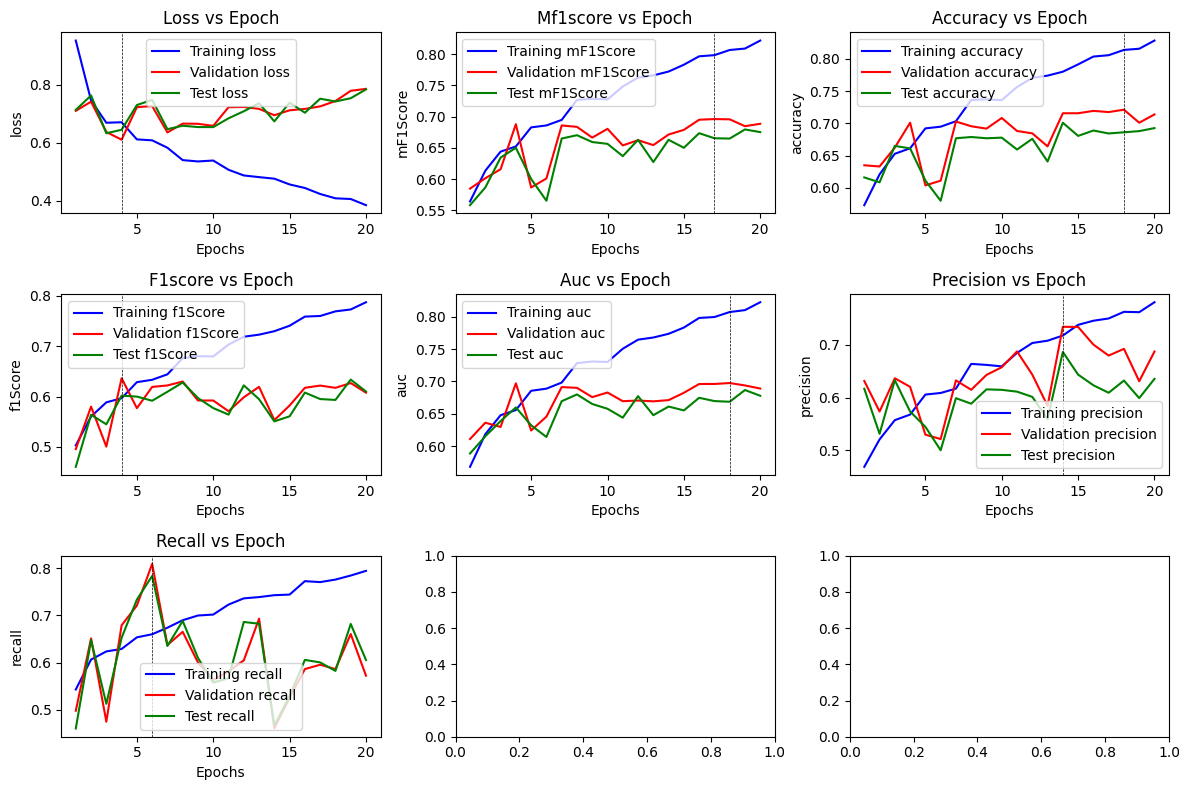

In [10]:
plot_all_metrics(performance_by_epoch)

In [11]:
name_of_entry = "MFCC+3FCL"
save_results(performance_by_epoch, name_of_entry)

Results saved successfully!


In [ ]:
from training.evaluation import get_metric_by_epoch
import matplotlib.pyplot as plt

In [ ]:
training_accuracy = get_metric_by_epoch("accuracy", "epoch_train_scores", performance_by_epoch)
val_accuracy = get_metric_by_epoch("accuracy", "epoch_val_scores", performance_by_epoch)
test_accuracy = get_metric_by_epoch("accuracy", "epoch_test_scores", performance_by_epoch)

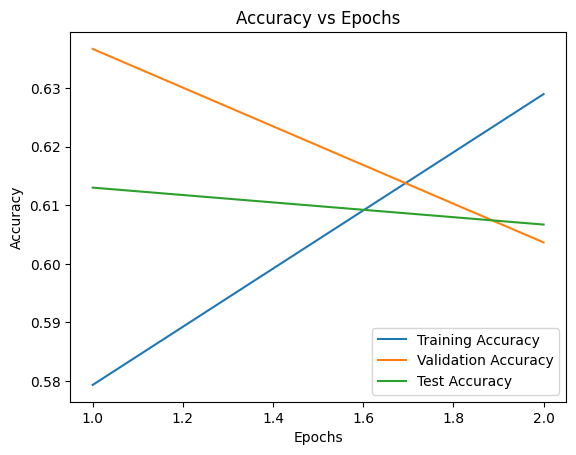

In [ ]:
epochs = range(1, len(training_accuracy)+1)

plt.plot(epochs, training_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.plot(epochs, test_accuracy, label='Test Accuracy')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')

# Adding legend
plt.legend()

# Display plot
plt.show()

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as data
import pickle
from sklearn.metrics import *
import numpy as np
import torch.nn as nn
from utils.utils import fix_the_random
from models.audio_model import FCL
from utils.utils import load_config
from training.evaluation import evalMetric
from training.train_vision import train, validation
from data_preprocessing.custom_datasets import Dataset_3DCNN, collate_fn
import warnings
warnings.filterwarnings('ignore')

In [ ]:
config = load_config('configs/configs.yaml')
fix_the_random(2021)

ROOT_FOLDER = config["ROOT_FOLDER"]
DATASET_FOLDER = config["DATASET_FOLDER"]

# training parameters
k = 2            # number of target category
epochs = config["EPOCHS"]
batch_size = config["BATCH_SIZE"]
learning_rate = config["LEARNING_RATE"]
log_interval = config["LOG_INTERVAL"]
num_workers = config["NUM_WORKERS"]
pin_memory = config["PIN_MEMORY"]

use_cuda = torch.cuda.is_available()                   # check if GPU exists
device = torch.device("cuda" if use_cuda else "cpu")   # use CPU or GPU

trainParams = {
    'batch_size': batch_size, 
    'shuffle': True, 
    'num_workers': num_workers, 
    'pin_memory': pin_memory} if use_cuda else {'batch_size': batch_size, 'shuffle': True}
valParams = {
    'batch_size': batch_size, 
    'shuffle': False, 
    'num_workers': num_workers, 
    'pin_memory': pin_memory} if use_cuda else {'batch_size': batch_size, 'shuffle': False}



d:\Buffalo\2024Spring\CSE676\676\CSE676-Deep-Learning-Final-Project


In [ ]:
# load k-fold indexes
with open(config["PICKLE_FOLDER"]+'allFoldDetails.p', 'rb') as fp:
    allDataAnnotation = pickle.load(fp)

In [ ]:
for fold in (allDataAnnotation.keys()):
    # train, test split
    train_list, train_label= allDataAnnotation[fold]['train_mfcc']
    val_list, val_label  =  allDataAnnotation[fold]['val_mfcc']
    test_list, test_label  =  allDataAnnotation[fold]['test_mfcc']

    train_set, valid_set , test_set = Dataset_3DCNN(train_list, train_label), Dataset_3DCNN(val_list, val_label), Dataset_3DCNN(test_list, test_label)
    train_loader = data.DataLoader(train_set, collate_fn = collate_fn, **trainParams)
    test_loader = data.DataLoader(test_set, collate_fn = collate_fn, **valParams)
    valid_loader = data.DataLoader(valid_set, collate_fn = collate_fn, **valParams)


KeyError: 'train_mfcc'

In [ ]:
for fold in allF:
    # train, test split
    train_list, train_label= allDataAnnotation[fold]['train_mfcc']
    val_list, val_label  =  allDataAnnotation[fold]['val_mfcc']
    test_list, test_label  =  allDataAnnotation[fold]['test_mfcc']


    train_set, valid_set , test_set = Dataset_3DCNN(train_list, train_label), Dataset_3DCNN(val_list, val_label), Dataset_3DCNN(test_list, test_label)
    train_loader = data.DataLoader(train_set, collate_fn = collate_fn, **trainParams)
    test_loader = data.DataLoader(test_set, collate_fn = collate_fn, **valParams)
    valid_loader = data.DataLoader(valid_set, collate_fn = collate_fn, **valParams)

    comb = FCL().to(device)

    # Parallelize model to multiple GPUs
    if torch.cuda.device_count() > 1:
        print("Using", torch.cuda.device_count(), "GPUs!")
        comb = nn.DataParallel(comb)

    optimizer = torch.optim.Adam(comb.parameters(), lr=learning_rate)

    epoch_train_losses = []
    epoch_train_scores = []
    epoch_test_losses = []
    epoch_test_scores = []

    validFinalValue = None
    testFinalValue = None
    finalScoreAcc =0
    prediction  = None

    # start training
    for epoch in range(epochs):
        # train, test model
        train_losses, train_scores = train(log_interval, comb, device, train_loader, optimizer, epoch)
        test_loss, test_scores, veTest_pred = validation(comb, device, optimizer, test_loader)
        test_loss1, test_scores1, veValid_pred = validation(comb, device, optimizer, valid_loader)
        if (test_scores1['mF1Score']>finalScoreAcc):
            finalScoreAcc = test_scores1['mF1Score']
            validFinalValue = test_scores1
            testFinalValue = test_scores
            prediction = {'test_list': test_list , 'test_label': test_label, 'test_pred': veTest_pred}

        # save results
        epoch_train_losses.append(train_losses)
        epoch_train_scores.append(list(x['accuracy'] for x in train_scores))
        epoch_test_losses.append(test_loss)
        epoch_test_scores.append(test_scores['accuracy'])


        # save all train test results
        A = np.array(epoch_train_losses)
        B = np.array(epoch_train_scores)
        C = np.array(epoch_test_losses)
        D = np.array(epoch_test_scores)
    finalOutputAccrossFold[fold] = {'validation':validFinalValue, 'test': testFinalValue, 'test_prediction': prediction}
        

with open('foldWiseRes_lstmVision.p', 'wb') as fp:
    pickle.dump(finalOutputAccrossFold,fp)
        